In [1]:
# Project cloning
!git clone https://github.com/nikitaoltyan/Mech-Trading-Systems.git
%cd Mech-Trading-Systems

fatal: destination path 'Mech-Trading-Systems' already exists and is not an empty directory.
/content/Mech-Trading-Systems


In [2]:
import pandas as pd
from PlotDraw import draw_plot

In [3]:
df = pd.read_excel("LHAG.xlsx")
df.head()

,<DATE>,<CLOSE>,<OPEN>,<HIGH>,<LOW>,<VOL>
0,"Dec 30, 2020",10.815,11.000,11.030,10.735,3.15M
1,"Dec 29, 2020",10.960,10.630,11.290,10.560,11.25M
2,"Dec 28, 2020",10.375,10.170,10.615,10.155,6.45M
3,"Dec 23, 2020",9.860,9.518,9.888,9.496,3.55M
4,"Dec 22, 2020",9.450,9.390,9.600,9.328,3.16M


In [4]:
df.astype({'<CLOSE>': 'int32', '<OPEN>': 'int32', '<HIGH>': 'int32', '<LOW>': 'int32'}).dtypes
df.astype({'<DATE>': 'datetime64[ns]'}).dtypes


<DATE>     datetime64[ns]
<CLOSE>           float64
<OPEN>            float64
<HIGH>            float64
<LOW>             float64
<VOL>              object
dtype: object

In [5]:
draw_plot(df, 0, len(df))

In [6]:
pip install mpl_finance

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as plt_dates
import matplotlib.ticker as plt_ticker

In [8]:
close = df['<CLOSE>']
open_ = df['<OPEN>']
high = df['<HIGH>']
low = df['<LOW>']

In [9]:
import numpy as np

In [10]:
def calc_ivar_indicator(data, n_ivar = 2, sma_1 = 3, sma_2 = 4):
    M = []
    N = []
    index = df.index
    ivar_data = df.copy()
    for i in range(len(ivar_data)):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        row_m = -1*sma_1 + 1
        row_n = -1*sma_2 + 1
        M.append(np.mean([close[i+row_m],close[i]]))
        N.append(np.mean([close[i+row_n],close[i]]))
      else:
        M.append(0)
        N.append(0)

    O = []
    for i in range(len(ivar_data)):
      if (2**n_ivar <= index[i]):
        row = -1*2**n_ivar + 1
        O.append(np.std([close[i+row],close[i]]))
      else:
        O.append(0)

    max_O = max(O)
    Q = []
    for i in range(len(index)):
      if (2**n_ivar <= index[i]):
        Q.append(O[i]/max_O)
      else:
        Q.append(0)

    S = [0]
    for i in range(1,len(index)-1):
      if ((index[i-1]>= 2**n_ivar) and (index[i-1]>=sma_1) and (index[i-1]>=sma_2)):
        if ((N[i-1]>=M[i-1] and N[i]<=M[i]) or (M[i-1]>N[i-1] and M[i]<N[i])) and (M[i]>=M[i-1] and N[i]>=N[i-1]):
          S.append('Покупка')
        elif ((N[i]>=M[i] and N[i+1]<=M[i+1]) or (M[i]>N[i] and M[i+1]<N[i+1])) and (M[i+1]<M[i] and N[i+1]<N[i]):
          S.append('Продажа')
        else:
          S.append(0)
      else:
        S.append(0)


    T = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if Q[i]<0.4:
          T.append('Тренд')
        elif 0.5>=Q[i]>=0.4:
          T.append('Коридор')
        elif Q[i]>0.5:
          T.append('Флет')
        else:
          T.append(0)
      else:
        T.append(0)

    ivar_data.drop(ivar_data.tail(1).index,inplace=True)

    ivar_data['Сигнал'] = T

    ivar_data['Cигнал по скользящим ср'] = S

    U = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if (S[i]=='Покупка' and T[i]=='Тренд'):
          U.append('Покупаем')
        elif (S[i]=='Покупка' and T[i]=='Коридор'):
          U.append('Можем купить')
        elif (S[i]=='Продажа' and T[i]=='Тренд'):
          U.append('Продаем')
        elif (S[i]=='Продажа' and T[i]=='Коридор'):
          U.append('Можем продать')
        else:
          U.append(0)
      else:
        U.append(0)

    ivar_data['промежуточное решение робота:'] = U


    V = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if (U[i] == 'Покупаем'):
          V.append(-open_[i])
        elif ((U[i] == 'Можем купить')):
          V.append(-open_[i])
        else:
          V.append(0)
      else:
        V.append(0)

    ivar_data['окончательного решения о покупке'] = V


    W = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if (U[i] == 'Продаем'):
          W.append(close[i])
        elif ((U[i] == 'Можем продать')):
          W.append(close[i])
        else:
          W.append(0)
      else:
        W.append(0)

    
    ivar_data['промежуточное решение робота о продаже:'] = W


    X = [0]
    Y = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if (V[i] < 0):
          X.append(1)
        else:
          X.append(0)
        if (W[i] > 0):
          Y.append(1)
        else:
          Y.append(0)
      else:
        X.append(0)
        Y.append(0)

    
    ivar_data['Индикатор покупки'] = X
    

    Z = [0]
    s = 0
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        s+=X[i]
        Z.append(s)
      else:
        Z.append(0)

    
    ivar_data['Накопленная покупка'] = Z


    AA = [0]
    s = 0
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        s+=Y[i]
        AA.append(s)
      else:
        AA.append(0)

    ivar_data['Накопленная продажа'] = AA


    AC = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if ((Z[i] > 0) and (Y[i] == 1)):
          AC.append(Z[i])
        else:
          AC.append(AC[i-1])
      else:
        AC.append(0)

    ivar_data['Последняя накопленная покупка:'] = AC


    AB = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if ((Z[i] - AC[i] > 0) and (Y[i] == 1)):
          AB.append(1)
        else:
          AB.append(0)
      else:
        AB.append(0)


    AC = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if ((Z[i] > 0) and (Y[i] == 1)):
          AC.append(Z[i])
        else:
          AC.append(AC[i-1])
      else:
        AC.append(0)

    ivar_data['Последняя накопленная покупка:'] = AC


    AD = [0]
    for i in range(1,len(index)-1):
      if ((index[i]>= 2**n_ivar) and (index[i]>=sma_1) and (index[i]>=sma_2)):
        if (AB[i-1] == 1) :
          AD.append(F[i]*(Z[i-1]*AC[i-1]))
        else:
          AD.append(0)
      else:
        AD.append(0)


    ivar_data['Окончательное решение о продаже'] = AD

    profit = sum(AD) + sum(V)

    capital = 1000000
    total = capital + profit
    m = capital/total

    return ivar_data, total

In [11]:
result, total = calc_ivar_indicator(df)
print(total)
result

997622.702


,<DATE>,<CLOSE>,<OPEN>,<HIGH>,<LOW>,<VOL>,Сигнал,Cигнал по скользящим ср,промежуточное решение робота:,окончательного решения о покупке,промежуточное решение робота о продаже:,Индикатор покупки,Накопленная покупка,Накопленная продажа,Последняя накопленная покупка:,Окончательное решение о продаже
0,"Dec 30, 2020",10.815,11.000,11.030,10.735,3.15M,0,0,0,0.0,0.0,0,0,0,0,0
1,"Dec 29, 2020",10.960,10.630,11.290,10.560,11.25M,0,0,0,0.0,0.0,0,0,0,0,0
2,"Dec 28, 2020",10.375,10.170,10.615,10.155,6.45M,0,0,0,0.0,0.0,0,0,0,0,0
3,"Dec 23, 2020",9.860,9.518,9.888,9.496,3.55M,0,0,0,0.0,0.0,0,0,0,0,0
4,"Dec 22, 2020",9.450,9.390,9.600,9.328,3.16M,Флет,0,0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,"Jan 11, 2016",14.655,14.850,14.995,14.640,6.88M,Тренд,0,0,0.0,0.0,0,144,128,142,0
1258,"Jan 08, 2016",14.920,15.060,15.140,14.840,5.90M,Тренд,0,0,0.0,0.0,0,144,128,142,0
1259,"Jan 07, 2016",15.010,14.800,15.150,14.615,8.07M,Тренд,0,0,0.0,0.0,0,144,128,142,0
1260,"Jan 06, 2016",15.160,14.910,15.410,14.900,8.04M,Тренд,0,0,0.0,0.0,0,144,128,142,0


In [12]:
result.iloc[1]

<DATE>                                     Dec 29, 2020
<CLOSE>                                           10.96
<OPEN>                                            10.63
<HIGH>                                            11.29
<LOW>                                             10.56
<VOL>                                            11.25M
Сигнал                                                0
Cигнал по скользящим ср                               0
промежуточное решение робота:                         0
окончательного решения о покупке                      0
промежуточное решение робота о продаже:               0
Индикатор покупки                                     0
Накопленная покупка                                   0
Накопленная продажа                                   0
Последняя накопленная покупка:                        0
Окончательное решение о продаже                       0
Name: 1, dtype: object

In [31]:
import matplotlib.pyplot as plt

In [27]:
import plotly.express as px


fig = px.line(result, x="<DATE>", y="<CLOSE>")
fig.add_vline(50,y0= 5, y1=1000)
# for i in range(len(result)):
#   if result.iloc[i]['окончательного решения о покупке'] < 0:
#     fig.add_vline(i,y0= result.iloc[i]['<CLOSE>'] - 1, y1= result.iloc[i]['<CLOSE>'] - 1) 
    
#   if result.iloc[i]['промежуточное решение робота о продаже:'] > 0:
#     fig.add_vline(i,y0= result.iloc[i]['<CLOSE>'] - 1, y1= result.iloc[i]['<CLOSE>'] - 1)

fig.show()

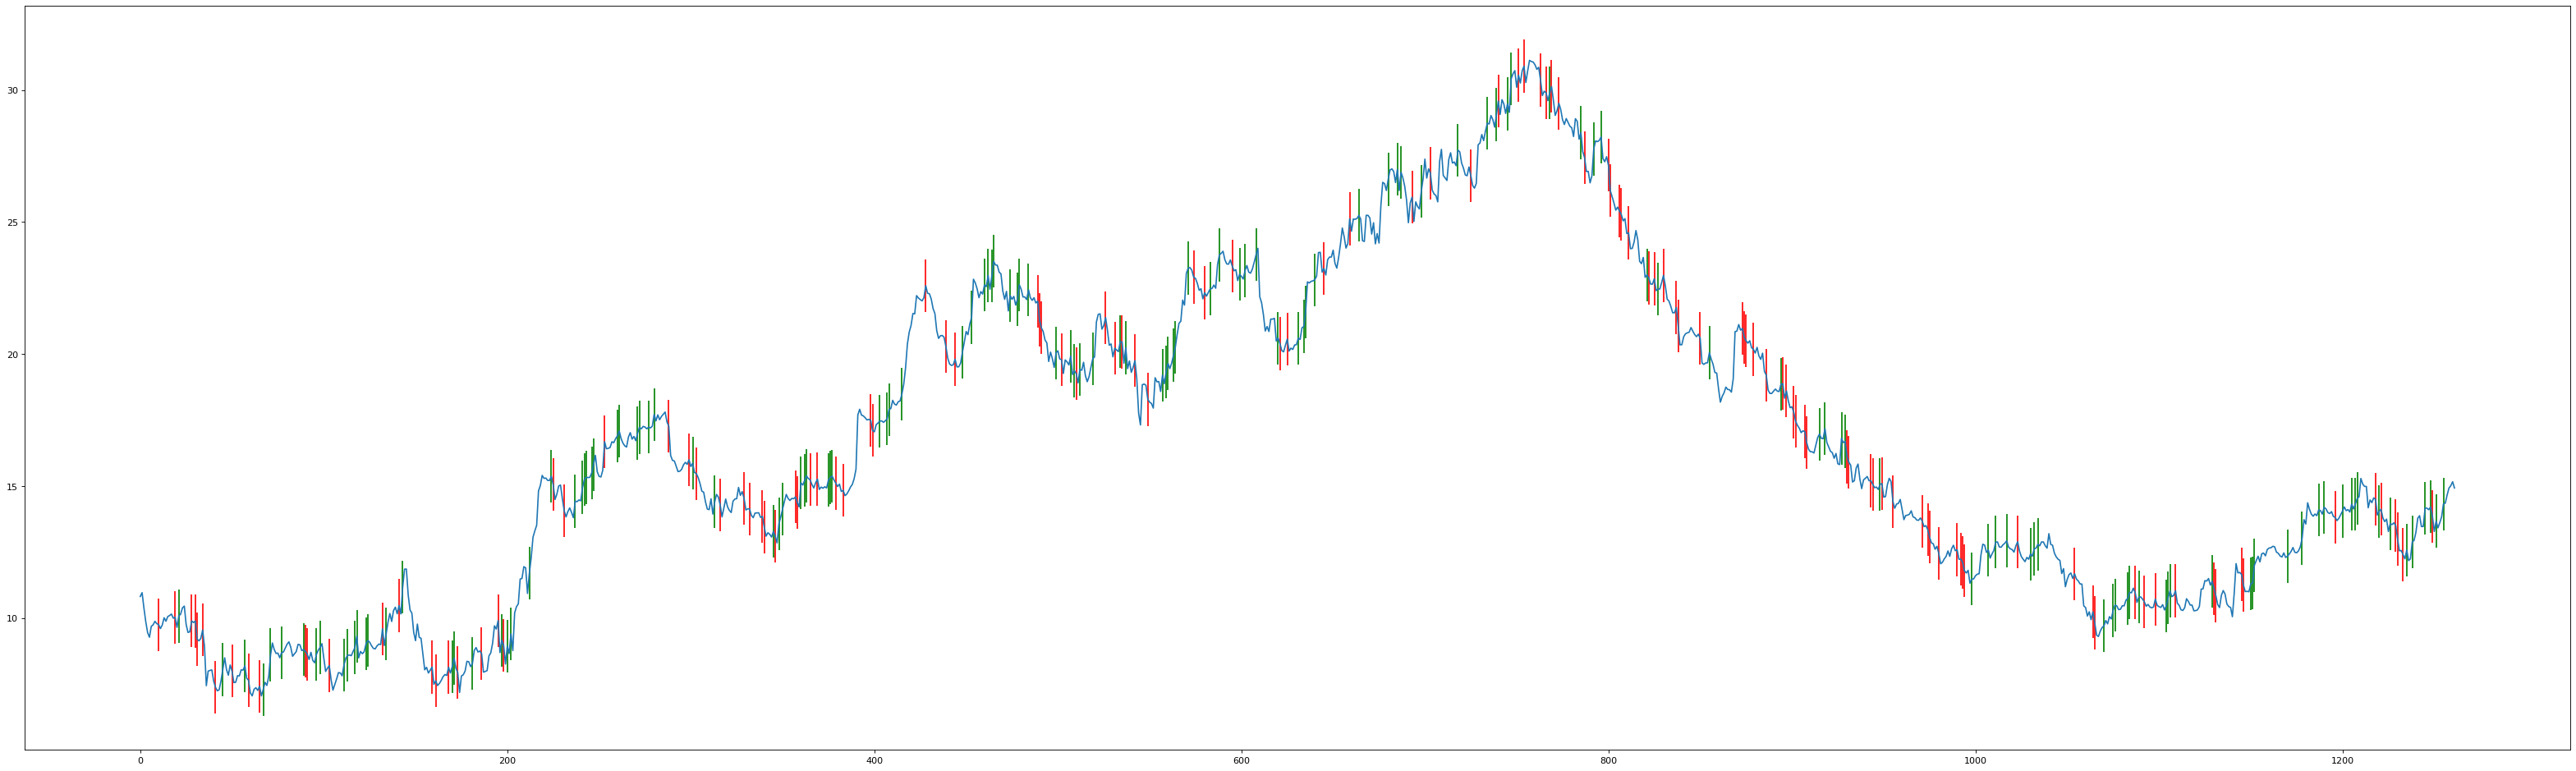

In [33]:
fig = plt.figure(figsize=(50, 15), dpi=80)

plt.plot(result['<CLOSE>'])

for i in range(len(result)):
  if result.iloc[i]['окончательного решения о покупке'] < 0:
    plt.vlines(i, result.iloc[i]['<CLOSE>'] - 1, 
               result.iloc[i]['<CLOSE>'] + 1, colors='g') 
    
  if result.iloc[i]['промежуточное решение робота о продаже:'] > 0:
    plt.vlines(i, result.iloc[i]['<CLOSE>'] - 1, 
               result.iloc[i]['<CLOSE>'] + 1, colors='r')